In [13]:
import os
import time
import collections
import random
from tqdm import tqdm
from typing import Tuple, Optional

import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [14]:
class PPO_Clip_Agent():
    """ Since the discrete actions have been redefined as {0,1} by env, we can simply represent the action by a number. """
    def __init__(self,
                 episode_recorder:object,
                 actor_network:torch.nn, 
                 critic_network:torch.nn,
                 actor_optimizer:torch.optim,
                 critic_optimizer:torch.optim,
                 gamma:float = 0.9,
                 advantage_lambda:float = 0.95,
                 clip_epsilon:float = 0.2, 
                 train_iters:int = 10, 
                 device:torch.device = torch.device("cpu")
                 ) -> None:
        
        self.device = device
        self.episode_recorder = episode_recorder
        self.actor_network = actor_network
        self.critic_network = critic_network
        self.actor_optimizer = actor_optimizer
        self.critic_optimizer = critic_optimizer              
        self.clip_epsilon = clip_epsilon
        self.train_iters = train_iters
        self.gamma = gamma
        self.advantage_lambda = advantage_lambda
        
    def get_action(self, obs:np.ndarray) -> int:
        obs = torch.tensor(obs, dtype = torch.float32).to(self.device)
        dist = self.actor_network(obs) # NN_outputs -softmax-> Action distribution
        dist = F.softmax(dist, dim = 0) 
        action_probs = torch.distributions.Categorical(dist)
        picked_action = action_probs.sample()
                       
        return picked_action.item()
    
    def calculate_log_prob(self, obs:torch.tensor, action:torch.tensor) -> torch.tensor:
        dist = F.softmax(self.actor_network(obs), dim=1)
        log_prob = torch.log(dist.gather(1, action))
        
        return log_prob
        
    
    def calculate_advantage(self, td_error:torch.tensor) -> torch.tensor:
        """ The advantage function is calculated by the TD error. """
        td_error = td_error.cpu().detach().numpy()
        advantage_list = []
        advantage = 0.0
        for delta in td_error[::-1]:
            advantage = self.gamma * self.advantage_lambda * advantage + delta
            advantage_list.append(advantage)
        advantage_list.reverse()
        advantage = torch.tensor(np.array(advantage_list), dtype = torch.float32).to(self.device)
        
        return advantage
    
    def train_policy(self) -> None:
        obs, action, reward, next_obs , done, = self.episode_recorder.get_trajectory()
        TD_target = reward + self.gamma * self.critic_network(next_obs) * (1 - done)
        TD_error = TD_target - self.critic_network(obs)
        advantage = self.calculate_advantage(TD_error)
        
        old_log_prob = self.calculate_log_prob(obs,action).detach() # Freeze the log_prob obtained by the current policy
        
        for _ in range(self.train_iters):
            critic_loss = torch.mean(F.mse_loss(TD_target.detach(), self.critic_network(obs)))
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
            
            log_prob = self.calculate_log_prob(obs, action)
            ratio = torch.exp(log_prob - old_log_prob) # pi_theta / pi_theta_old
            clipped_ratio = torch.clamp(ratio, 1-self.clip_epsilon, 1+self.clip_epsilon)
            actor_loss = torch.mean(-torch.min(ratio * advantage, clipped_ratio * advantage))
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()


class Actor_Network(torch.nn.Module):

    def __init__(self,obs_dim:int,action_dim:int) -> None:
        super(Actor_Network, self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,action_dim)
                    
    def forward(self,x:torch.tensor) -> torch.tensor:
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
                
        return x
    
class Critic_Network(torch.nn.Module):

    def __init__(self,obs_dim:int) -> None:
        super(Critic_Network, self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,1)
                    
    def forward(self,x:torch.tensor) -> torch.tensor:
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
                
        return x
    

class Episode_Recorder():
    
    def __init__(self, device:torch.device = torch.device("cpu")) -> None:
        self.device = device
        self.reset()
        
    def append(self, 
               obs: np.ndarray,
               action: int,
               reward:float,
               next_obs: np.ndarray,
               done: bool
               ) -> None:
        obs = torch.tensor(np.array([obs]), 
                           dtype = torch.float32).to(self.device)
        action = torch.tensor(np.array([[action]]), 
                              dtype = torch.int64).to(self.device)
        reward = torch.tensor(np.array([[reward]]), 
                              dtype = torch.float32).to(self.device)
        next_obs = torch.tensor(np.array([next_obs]), 
                                dtype = torch.float32).to(self.device)
        done = torch.tensor(np.array([[done]]), 
                            dtype = torch.float32).to(self.device)
        self.trajectory["obs"] = torch.cat((self.trajectory["obs"], obs))
        self.trajectory["action"] = torch.cat((self.trajectory["action"], action))
        self.trajectory["reward"] = torch.cat((self.trajectory["reward"], reward))
        self.trajectory["next_obs"] = torch.cat((self.trajectory["next_obs"], next_obs))
        self.trajectory["done"] = torch.cat((self.trajectory["done"], done))
        
    def get_trajectory(self) -> Tuple[torch.tensor, torch.tensor, torch.tensor, torch.tensor, torch.tensor, torch.tensor]:
        
        return self.trajectory["obs"], self.trajectory["action"], \
            self.trajectory["reward"], self.trajectory["next_obs"], self.trajectory["done"]
    
    def reset(self) -> None:
        """ Clear the trajectory when begin a new episode."""
        self.trajectory = {
            "obs": torch.tensor([], dtype = torch.float32).to(self.device),
            "action": torch.tensor([], dtype = torch.int64).to(self.device),
            "reward": torch.tensor([], dtype = torch.float32).to(self.device),
            "next_obs": torch.tensor([], dtype = torch.float32).to(self.device),
            "done": torch.tensor([], dtype = torch.float32).to(self.device)
        }

In [15]:
class BC_Agent():
    """Behavioral Cloning Agent"""
    def __init__(self,
        input_dim:int,
        output_dim:int,
        policy_network:torch.nn.Module,
        optimizer:torch.optim.Optimizer,
        device:torch.device = torch.device("cpu")
    ) -> None: 
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.policy_network = policy_network
        self.optimizer = optimizer
        self.device = device
        
    def predict(self, obs:np.ndarray)->torch.tensor:
        obs = torch.tensor(obs, dtype = torch.float32).to(self.device)
        dist = self.policy_network(obs)
        # action_probs = torch.distributions.Categorical(dist)
        # picked_action = action_probs.sample()
        picked_action = torch.argmax(dist)

        return picked_action
    
    def learn(self, 
        obs:torch.tensor, 
        action:torch.tensor
    ) -> None:
        log_prob = torch.log(self.policy_network(obs).gather(1, action.unsqueeze(-1)))
        loss = torch.mean(-log_prob)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
class Policy_Network(torch.nn.Module):
    def __init__(
        self,
        input_dim:int, 
        output_dim:int
    ) -> None:
        super(Policy_Network, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 64)
        self.fc2 = torch.nn.Linear(64, output_dim)
        
    def forward(self, x:torch.tensor) -> torch.tensor:
        x = F.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

In [16]:
class ReplayBuffer():
    """Expert experience collector"""
    def __init__(
        self, 
        capacity:int, 
        device:torch.device = torch.device("cpu")
    ) -> None:
        self.device = device
        self.buffer = collections.deque(maxlen=capacity)
        
    def append(self,exp_data:tuple) -> None:
        self.buffer.append(exp_data)
        
    def sample(self,batch_size:int) -> Tuple[torch.tensor,torch.tensor]:
        batch_size = min(batch_size, len(self.buffer)) # in case the buffer is not enough        
        mini_batch = random.sample(self.buffer,batch_size)
        obs_batch, action_batch = zip(*mini_batch)
        obs_batch = torch.tensor(np.array(obs_batch),dtype=torch.float32,device=self.device)
        action_batch = torch.tensor(np.array(action_batch),dtype=torch.int64,device=self.device) 
          
        return obs_batch, action_batch
    
    def fetch_all(self) -> Tuple[torch.tensor,torch.tensor]:
        obs_batch, action_batch = zip(*self.buffer)
        obs_batch = torch.tensor(np.array(obs_batch),dtype=torch.float32,device=self.device)
        action_batch = torch.tensor(np.array(action_batch),dtype=torch.int64,device=self.device) 
          
        return obs_batch, action_batch
    
    def release(self) -> None:
        self.buffer.clear()
        
    def __len__(self) -> int:
        return len(self.buffer)

In [17]:
class TrainManager():
    def __init__(
        self,
        train_env:gym.Env,
        test_env:gym.Env,
        ppo_train_episode_num:int = 200,
        actor_lr:float = 1e-3,
        critic_lr:float = 1e-2,
        gamma:float = 0.9,
        advantage_lambda:float = 0.95,
        clip_epsilon:float = 0.2,
        ppo_train_iters:int = 10,
        bc_lr:float = 0.001,
        bc_train_iters:int = 10,
        buffer_capacity:int = 1000000,
        bc_batch_size:int = 64,
        bc_train_episode_num:int = 1000,
        test_iters:int = 5,
        device:torch.device = torch.device("cpu"),
        seed:Optional[int] = None
    ) -> None:
        # Envs
        self.train_env = train_env
        self.test_env = test_env
        obs_dim = gym.spaces.utils.flatdim(train_env.observation_space) 
        action_dim = train_env.action_space.n
        self.device = device
        # Seeds
        _,_ = self.train_env.reset(seed=seed) # Seed for training
        _,_ = self.test_env.reset(seed=seed+1) # Seed for testing
        random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        torch.backends.cudnn.deterministic = True
        # Expert PPO
        self.ppo_train_episode_num = ppo_train_episode_num
        episode_recorder = Episode_Recorder(device = self.device)
        actor_network = Actor_Network(obs_dim,action_dim).to(self.device)
        actor_optimizer = torch.optim.Adam(actor_network.parameters(),lr=actor_lr)
        critic_network = Critic_Network(obs_dim).to(self.device)
        critic_optimizer = torch.optim.Adam(critic_network.parameters(),lr=critic_lr)
        self.ppo_agent = PPO_Clip_Agent(episode_recorder = episode_recorder,
                                    actor_network = actor_network, 
                                    critic_network = critic_network,
                                    actor_optimizer = actor_optimizer,
                                    critic_optimizer = critic_optimizer,
                                    gamma = gamma,
                                    advantage_lambda = advantage_lambda,
                                    clip_epsilon = clip_epsilon,
                                    train_iters = ppo_train_iters,
                                    device = self.device
                                    )
        # BC
        self.bc_train_episode_num = bc_train_episode_num
        self.bc_train_iters = bc_train_iters                                    
        self.buffer = ReplayBuffer(capacity=buffer_capacity, device=self.device)
        self.bc_batch_size = bc_batch_size
        self.test_iters = test_iters
        policy_network = Policy_Network(obs_dim, action_dim).to(self.device)
        bc_optimizer = torch.optim.Adam(policy_network.parameters(), lr=bc_lr)
        self.bc_agent = BC_Agent(
            input_dim = obs_dim, output_dim = action_dim,
            policy_network = policy_network, optimizer = bc_optimizer
        )
        
        self.test_returns_mean = []
        self.test_returns_max = []
        self.test_returns_min = []
         
        pass

    def train_ppo(self) -> None:
        self.episode_total_rewards = np.zeros(self.ppo_train_episode_num)
        self.index_episode = 0
        tic = time.perf_counter()  # start clock
        with tqdm(total=self.ppo_train_episode_num, desc='ExpertPPO_Training') as pbar:
            for _ in range(self.ppo_train_episode_num):
                episode_reward = self.train_ppo_episode()
                toc = time.perf_counter()
                pbar.set_postfix({"Training time": f"{toc - tic:0.2} seconds", "Return": (episode_reward)})
                pbar.update(1)
        
    def train_ppo_episode(self) -> float:
        total_reward = 0
        self.ppo_agent.episode_recorder.reset()
        obs,_ = self.train_env.reset() 
        while True:
            action = self.ppo_agent.get_action(obs) 
            next_obs, reward, terminated, truncated, _ = self.train_env.step(action)
            done = terminated or truncated
            self.ppo_agent.episode_recorder.append(obs, action, reward, next_obs, done)
            total_reward += reward 
            obs = next_obs              
            if done:
                self.episode_total_rewards[self.index_episode] = total_reward
                self.index_episode += 1
                break
        
        self.ppo_agent.train_policy()
        
        return total_reward
        
    def sample_expert_data(self, n_episode:int, n_samples:int) -> None:
        for _ in range(n_episode):
            state,_ = self.train_env.reset()
            done = False
            while not done:
                action = self.ppo_agent.get_action(state)
                next_state, _, terminated, truncated, _ = self.train_env.step(action)
                done = terminated or truncated
                self.buffer.append((state, action))
                state = next_state
        
        self.exp_obs, self.exp_action = self.buffer.sample(n_samples)
    
    def train_bc(self) -> None:
        tic = time.perf_counter()
        with tqdm(total=self.bc_train_episode_num, desc='BC_Training') as pbar:
            for _ in range(self.bc_train_episode_num):
                self.train_bc_episode()
                r_mean,r_max,r_min = self.bc_test()
                self.test_returns_mean.append(r_mean)
                self.test_returns_max.append(r_max)
                self.test_returns_min.append(r_min)
                toc = time.perf_counter()
                pbar.set_postfix({"Training time": f"{toc - tic:0.2} seconds", "Avg.Return": (r_mean)})
                pbar.update(1)
    
    def train_bc_episode(self) -> None:
        for _ in range(self.bc_train_iters):
            sample_indices = np.random.randint(low=0,
                                           high=self.exp_obs.shape[0],
                                           size=self.bc_batch_size)
            self.bc_agent.learn(self.exp_obs[sample_indices], self.exp_action[sample_indices])    
    
    def bc_test(self) -> Tuple[float, float, float]:
        return_list = []
        for _ in range(self.test_iters):
            obs, _ = self.test_env.reset()
            done = False
            episode_return = 0
            while not done:
                action = int(self.bc_agent.predict(obs).item())
                next_obs, reward, terminated, truncated, _ = self.test_env.step(action)
                done = terminated or truncated
                obs = next_obs
                episode_return += reward
                
            return_list.append(episode_return)
            
        return np.mean(return_list), np.max(return_list), np.min(return_list)

In [18]:
train_env = gym.make('CartPole-v0')
test_env = gym.make('CartPole-v0')

"""Using 30 samples"""
Manger = TrainManager(
        train_env=train_env,
        test_env = test_env,
        ppo_train_episode_num = 200,
        actor_lr = 1e-3,
        critic_lr = 1e-2,
        gamma = 0.98,
        advantage_lambda = 0.95,
        clip_epsilon = 0.2,
        ppo_train_iters = 10,
        bc_lr = 1e-3,
        bc_train_iters = 10,
        bc_batch_size = 64,
        bc_train_episode_num = 1000,
        buffer_capacity = 1000000,
        test_iters = 5,
        device = torch.device("cpu"),
        seed = 0,
)

Manger.train_ppo()
# Manger.ppo_plotting(smoothing_window = 10)
Manger.sample_expert_data(n_episode=1,n_samples=30)
Manger.train_bc()
r30_mean = Manger.test_returns_mean
r30_max = Manger.test_returns_max
r30_min = Manger.test_returns_min

BC_Training: 100%|██████████| 1000/1000 [01:49<00:00,  9.16it/s, Training time=1.1e+02 seconds, Avg.Return=200]


In [19]:
"""Using 15 samples"""
Manger = TrainManager(
        train_env=train_env,
        test_env = test_env,
        ppo_train_episode_num = 200,
        actor_lr = 1e-3,
        critic_lr = 1e-2,
        gamma = 0.98,
        advantage_lambda = 0.95,
        clip_epsilon = 0.2,
        ppo_train_iters = 10,
        bc_lr = 1e-3,
        bc_train_iters = 10,
        bc_batch_size = 64,
        bc_train_episode_num = 1000,
        buffer_capacity = 1000000,
        test_iters = 5,
        device = torch.device("cpu"),
        seed = 0,
)

Manger.train_ppo()
Manger.sample_expert_data(n_episode=1,n_samples=15)
Manger.train_bc()
r15_mean = Manger.test_returns_mean
r15_max = Manger.test_returns_max
r15_min = Manger.test_returns_min

BC_Training: 100%|██████████| 1000/1000 [01:55<00:00,  8.68it/s, Training time=1.2e+02 seconds, Avg.Return=200]


In [20]:
"""Using 3 samples"""
Manger = TrainManager(
        train_env=train_env,
        test_env = test_env,
        ppo_train_episode_num = 200,
        actor_lr = 1e-3,
        critic_lr = 1e-2,
        gamma = 0.98,
        advantage_lambda = 0.95,
        clip_epsilon = 0.2,
        ppo_train_iters = 10,
        bc_lr = 1e-3,
        bc_train_iters = 10,
        bc_batch_size = 64,
        bc_train_episode_num = 1000,
        buffer_capacity = 1000000,
        test_iters = 5,
        device = torch.device("cpu"),
        seed = 0,
)

Manger.train_ppo()
Manger.sample_expert_data(n_episode=1,n_samples=3)
Manger.train_bc()
r3_mean = Manger.test_returns_mean
r3_max = Manger.test_returns_max
r3_min = Manger.test_returns_min

BC_Training: 100%|██████████| 1000/1000 [00:35<00:00, 27.91it/s, Training time=3.6e+01 seconds, Avg.Return=49.2]


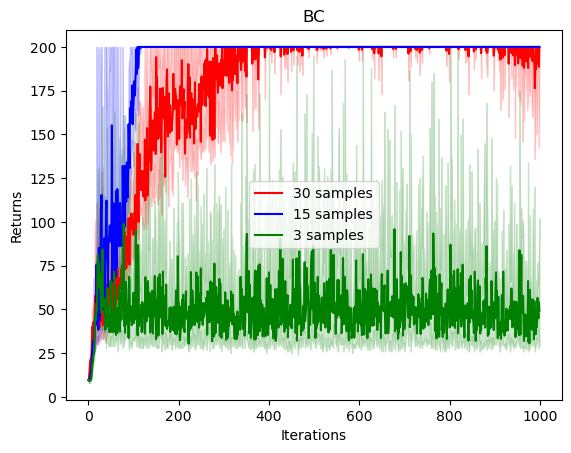

In [21]:
iteration_list = list(range(len(r30_mean)))
plt.plot(iteration_list, r30_mean, label='30 samples', color="red")
plt.fill_between(iteration_list, r30_min, r30_max, alpha=0.2, color="red")
plt.plot(iteration_list, r15_mean, label='15 samples', color="blue")
plt.fill_between(iteration_list, r15_min, r15_max, alpha=0.2, color="blue")
plt.plot(iteration_list, r3_mean, label='3 samples', color="green")
plt.fill_between(iteration_list, r3_min, r3_max, alpha=0.2, color="green")
plt.xlabel('Iterations')
plt.ylabel('Returns')
plt.title("BC")
plt.legend()
plt.show()